# Exploring the variety of phrasing in baroque music performance

### Introduction
Many people have the impression that Bach should be played in a stiff and mechanical way since this is how people are often taught to play Bach at a young age. The reality is that baroque performance practice is a highly varied and nuanced art form.
In this Jupyter notebook I explore the phrasing attributes of three distinct performance styles of historical Baroque music.

This project showcases:
- **Visualization of high dimensional data:** Using t-squared stochastic neighbor embedding (t-SNE), I show how high-dimensional data can be effectively visualized.
- **Input feature comparison:** I compare two sets of input features by using them to train a machine learning classifier and comparing the resulting accuracies.
- **Importance of domain knowledge:** By leveraging knowledge of music performance I was able to improve the ability of a classifier to predict performance style by 20% through improved feature engineering.


### Background
I took inspiration from a [musicology paper](https://www.researchgate.net/publication/301285596_Baroque_expressiveness_and_stylishness_in_three_recordings_of_the_D_minor_Sarabanda_for_solo_violin_by_JS_Bach) which identified three distinct performance styles of baroque music. These styles, initially identified by expert musicologists were then verified by experienced listeners. Phrasing was one dimension where listeners were able to reliably identify the different performance styles. Expressive phrasing, it has been shown, is accomplished via variations of tempo and loudness ([source](https://doi.org/10.1037/0096-1523.15.2.331)).

### Load raw tempo and loudness 
Below I load the raw tempo and loudness time-series data. Tempo, measured in beats-per-minute (BPM), and loudness, measured in decibels (dB), were extracted from raw audio signals by leveraging music information retrieval (MIR) techniques using MATLAB. For more information about how I did this, you can see my [PhD manuscript](https://www.theses.fr/2023CYUN1166).
(NB: I use the term "loudness" here for its familiarity even though "intensity" is  more accurate).

In [1]:
import pandas as pd
import numpy as np

# Load raw tempo and loudness
df_phrasing_raw = pd.read_csv('rawTempoLoudness.csv', index_col=0)

# Get labels for musicians
perf_labels_raw = df_phrasing_raw.index.str.split('_').str[0].values

# Get labels for compositions (pieces)
piece_labels_raw = df_phrasing_raw.index.str.split('_').str[1].values

df_phrasing_raw.round(2).head()

,raw_tempo,raw_loudness
Row,,
Grumiaux_Gavotte_1,68.08,-18.99
Grumiaux_Gavotte_2,74.01,-16.34
Grumiaux_Gavotte_3,74.01,-16.71
Grumiaux_Gavotte_4,93.75,-17.09
Grumiaux_Gavotte_5,61.14,-20.20


The index labels contain the name of the performer, the name of the composition, and the note number. There are three performers representing three different performance styles. Three different compositions were chosen to represent a variety of compositional styles in Baroque music.

### Plot tempo and loudness
TO DO: redo thesee plots with loop as the t-SNE onees below


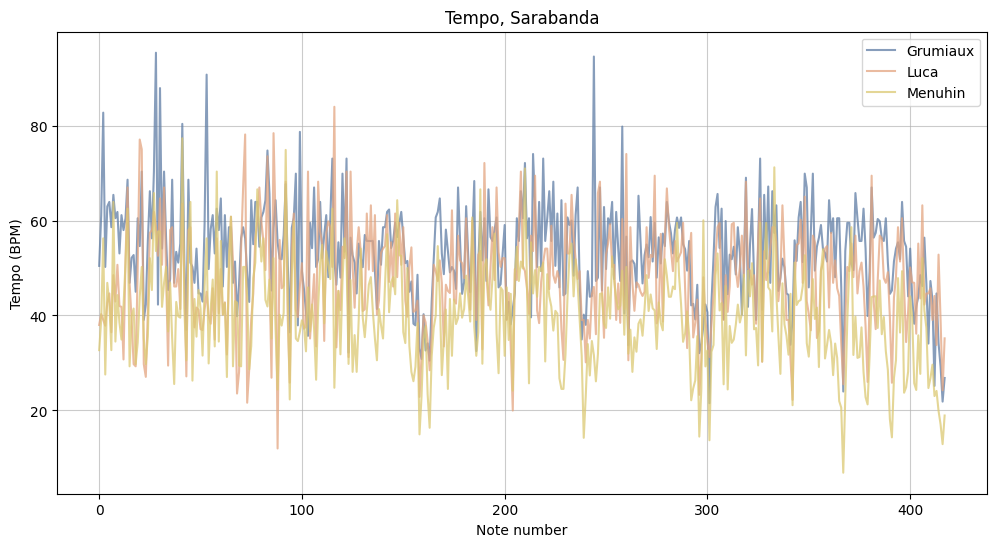

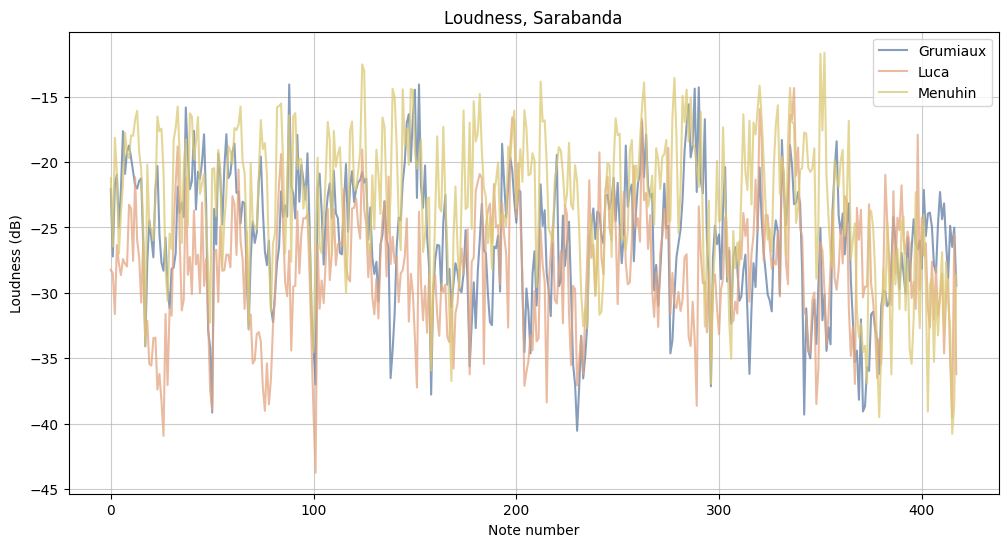

In [11]:
import matplotlib.pyplot as plt

# Define color palette
blue = '#5F7Da5'
orange = '#E3A580'
gold = '#DCC973'

cur_piece = 'Sarabanda'
cur_perf_labels = perf_labels_raw[piece_labels_raw == cur_piece]
cur_tempo = df_phrasing_raw.raw_tempo.values[piece_labels_raw == cur_piece]
cur_loudness = df_phrasing_raw.raw_loudness.values[piece_labels_raw == cur_piece]

fig = plt.figure(figsize=(12, 6))
plt.plot(cur_tempo[cur_perf_labels == 'Grumiaux'], color=blue, alpha=0.75, label='Grumiaux')
plt.plot(cur_tempo[cur_perf_labels == 'Luca'], color=orange, alpha=0.75, label='Luca')
plt.plot(cur_tempo[cur_perf_labels == 'Menuhin'], color=gold, alpha=0.75, label='Menuhin')
plt.xlabel('Note number')
plt.ylabel('Tempo (BPM)')
plt.title('Tempo, Sarabanda')
plt.legend(loc='best')
plt.grid(True, alpha=0.65)
#plt.savefig("tempo_time_series.png", format='png', dpi=300, bbox_inches='tight')
plt.show()

fig = plt.figure(figsize=(12, 6))
plt.plot(cur_loudness[cur_perf_labels == 'Grumiaux'], color=blue, alpha=0.75, label='Grumiaux')
plt.plot(cur_loudness[cur_perf_labels == 'Luca'], color=orange, alpha=0.75, label='Luca')
plt.plot(cur_loudness[cur_perf_labels == 'Menuhin'], color=gold, alpha=0.75, label='Menuhin')
plt.xlabel('Note number')
plt.ylabel('Loudness (dB)')
plt.title('Loudness, Sarabanda')

plt.legend(loc='best')
plt.grid(True, alpha=0.65)
#plt.savefig("loudness_time_series.png", format='png', dpi=300, bbox_inches='tight')
plt.show()

While the plots are a little noisy, you can see some differences between the different performers. The noisiness of the note-level tempo and loudness could be a potential problem. So, I decided to design a  set of input features that I hoped would better capture expressive phrasing based on my knowledge of music performance. Phrasing is accomplished through both local and global variations in tempo and loudness, so I decided to break up the time series data into segments of different, musically meaningful, lengths (1, 2, 4, 8, and 16-bar phrases) and use summary statistics (range, standard deviation, and coefficients of a polynomial fit) of these segments as input features.

### Loading engineered input features

In [5]:
# Load phrasing features into dataframe
df_phrasing = pd.read_csv('phrasing_feats.csv', index_col=1)

# Clean up data a bita
df_phrasing.drop(columns=['Unnamed: 0','DynIQR','TempIQR'], inplace=True) # remove unused features

# Get labels for musicians
perf_labels = df_phrasing.index.str.split(' ').str[0].values

# Get labels for compositions (pieces)
piece_labels = df_phrasing.index.str.split(' ').str[1].values

# Display first few rows
df_phrasing.round(2).head()

,DynRange,DynStDev,TempRange,TempStDev,DynPolyCoeff1,DynPolyCoeff2,DynPolyCoeff3,TempPolyCoeff1,TempPolyCoeff2,TempPolyCoeff3
Row,,,,,,,,,,
Grumiaux Gavotte bar: 1,18.48,7.41,10.13,3.70,-0.01,0.10,-17.18,-0.75,4.56,70.63
Grumiaux Gavotte bar: 2,12.98,6.05,16.36,10.02,0.01,-0.54,-15.41,-2.21,15.21,57.27
Grumiaux Gavotte bar: 3,12.19,5.33,20.78,10.31,-0.00,0.00,-21.91,-0.26,4.47,67.29
Grumiaux Gavotte bar: 4,14.08,4.56,17.09,5.16,0.00,0.26,-25.34,-0.54,4.01,81.32
Grumiaux Gavotte bar: 5,9.06,2.89,13.64,11.07,0.00,-0.02,-18.71,-0.83,7.64,67.82


### Normalize data

In [6]:
from sklearn.preprocessing import StandardScaler

# Normalize data
scaler = StandardScaler()
phrasing_norm = scaler.fit_transform(df_phrasing.values)
phrasing_norm_raw = scaler.fit_transform(df_phrasing_raw.values)

### Visualize engineered features

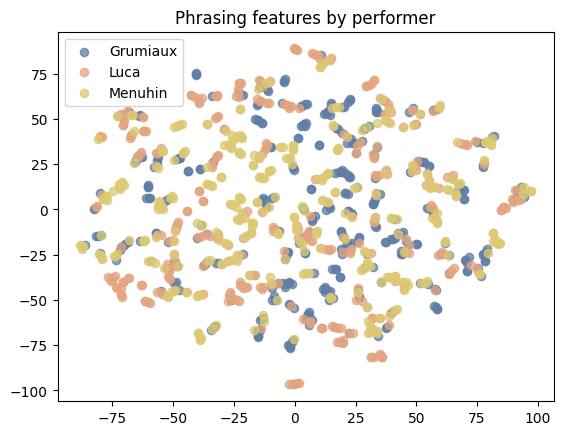

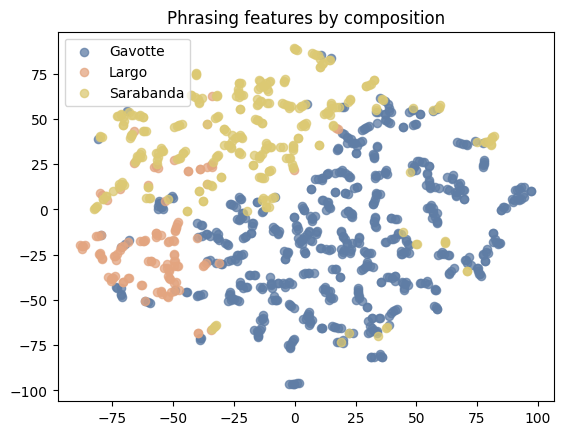

In [8]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Define color palette
blue = '#5F7Da5'
orange = '#E3A580'
gold = '#DCC973'

# Perform t-SNE to reduce dimensions
phrasing_tsne = TSNE(n_components=2, learning_rate='auto',
                 init='random', perplexity=3).fit_transform(phrasing_norm)

# Plot scatter plot separated by class (performer)
colors = [blue, orange, gold]
perf_names = pd.unique(perf_labels)
for color, perf in zip(colors, perf_names):
    cur_perf_indices = perf_labels == perf
    x, y = phrasing_tsne[cur_perf_indices,0], phrasing_tsne[cur_perf_indices,1]
    plt.scatter(x, y, s=35, c=color, label=perf, alpha=0.75)   
plt.legend()
plt.title('Phrasing features by performer')
#plt.savefig("tsne_performer.png", format='png', dpi=300, bbox_inches='tight')
plt.show()

# Different scatter plot with class label being composition
piece_names = pd.unique(piece_labels)
for color, piece in zip(colors, piece_names):
    cur_piece_indices = piece_labels == piece
    x, y = phrasing_tsne[cur_piece_indices,0], phrasing_tsne[cur_piece_indices,1]
    plt.scatter(x, y, s=35, c=color, label=piece, alpha=0.75)   
plt.legend()
plt.title('Phrasing features by composition')
#plt.savefig("tsne_composition.png", format='png', dpi=300, bbox_inches='tight')
plt.show()

Because I am now using 10 dimensions to represent the phrasing, I used t-SNE to reduce the data to two dimensions before plotting it. In the first plot there doesn't seem to be very obvious separation between the classes. As a sanity check I also included a similar visualization but showing the different compositions instead. One should expect this to show much clearer class separation since the variation of tempo and loudness is much greater across compositions than it is across performance style, which is much more subtle. The visualizations show that this intuition was correct, so we can have some faith that these features are capture variations in tempo and loudness well.

### Comparison of features via classifier performance

Now, in order to get a better idea at how well these features can characterize performance styles I'm going to train a learning algorithm on these two different feature sets to see how they compare. I chose a support vector machine (SVM) classifier with a radial basis function kernel and 5-fold cross validation. I report the total mean accuracy of all folds since the classes are balanced in this case.

In [9]:
# Train classifier
from sklearn import svm
from sklearn.model_selection import cross_val_score, KFold

# Create SVM classifier object
svm_classifier = svm.SVC(kernel='rbf')

# Create cross-validation object
k_fold = KFold(n_splits=5, shuffle=True)

# Calculate mean accuracy across folds for performer
scores = cross_val_score(svm_classifier, phrasing_norm, perf_labels, cv=k_fold, scoring='accuracy')
print("Performer prediction results:")
print(f"Mean accuracy: {np.mean(scores):.4f}")
print(f"Standard Deviation: {np.std(scores):.4f}")

# Calculate mean accuracy across folds for performer on raw data
scores = cross_val_score(svm_classifier, phrasing_norm_raw, perf_labels_raw, cv=k_fold, scoring='accuracy')
print("\nPerformer prediction results on raw data:")
print(f"Mean accuracy: {np.mean(scores):.4f}")
print(f"Standard Deviation: {np.std(scores):.4f}")

Performer prediction results:
Mean accuracy: 0.6745
Standard Deviation: 0.0250

Performer prediction results on raw data:
Mean accuracy: 0.4784
Standard Deviation: 0.0126


### Results
Using the designed features, I was able to achieve an accuracy of around 68%. Compared to random chance (33%), this is not bad.

Furthermore, the results using the engineered features show a roughly 20% improvement in classification accuracy over the raw features. This means that using summary statistics of tempo and loudness of musically meaningful durations provides fewer but more meaningful data points than the raw time-series data.

This demonstrates the importance of domain knowledge when engineering features for use in learning algorithms.

### Takeaways
This type of research is useful in a number of areas including:
- Improving music recommendation algorithms, especially for classical music in which there are numerous recordings of the same composition.
- Enhancing pedagogical strategies in music performance
- Providing empirical support to previously existing theories in musicology

### Future work
An expanded dataset of recordings annotated by expert musicologists and experienced listeners would be hugely beneficial in the development of better input features. Additionally, access to more recordings could help to reveal the robustness of these features.